In [1]:
%matplotlib inline


Diferentes clasificadores en la decodificación del conjunto de datos Haxby
=====================================================

Comparación de diferentes clasificadores en una tarea de decodificación de reconocimiento de objetos visuales.



1) Cargar los datos y aplicarle transformaciones simples

In [2]:
# Obtener datos usando la captura de conjunto de datos nilearn
from nilearn import datasets
haxby_dataset = datasets.fetch_haxby()

# imprimir información básica sobre el conjunto de datos
print('First subject anatomical nifti image (3D) located is at: %s' %
      haxby_dataset.anat[0])
print('First subject functional nifti image (4D) is located at: %s' %
      haxby_dataset.func[0])

# cargar etiquetas 
import numpy as np
import pandas as pd
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
stimuli = labels['labels']
# identificar las etiquetas de estado en reposo para poder descartarlas
task_mask = (stimuli != 'rest')

# encontrar nombres de las etiquetas activas restantes
categories = stimuli[task_mask].unique()

# extraer etiquetas que indiquen a qué adquisición (estimulación) pertenece
session_labels = labels['chunks'][task_mask]

 # Cargar los datos de fMRI
from nilearn.input_data import NiftiMasker

# Para la decodificación, la estandarización a menudo es muy importante
mask_filename = haxby_dataset.mask_vt[0]
masker = NiftiMasker(mask_img=mask_filename, standardize=True)
func_filename = haxby_dataset.func[0]
masked_timecourses = masker.fit_transform(func_filename)[task_mask]

Downloaded 291168628 of 291168628 bytes (100.0%,    0.0s remaining) ...done. (932 seconds, 15 min)
Extracting data from /home/aletrujim/nilearn_data/haxby2001/f33ff337e914bf7fded743c7107979f9/subj2-2010.01.14.tar.gz..... done.


First subject anatomical nifti image (3D) located is at: /home/aletrujim/nilearn_data/haxby2001/subj2/anat.nii.gz
First subject functional nifti image (4D) is located at: /home/aletrujim/nilearn_data/haxby2001/subj2/bold.nii.gz


2) Definir los diferentes clasificadores a usar


In [3]:
# Clasificador de vectores de soporte
from sklearn.svm import SVC
svm = SVC(C=1., kernel="linear")

# Regresión logistica
from sklearn.linear_model import (LogisticRegression,
                                  RidgeClassifier,
                                  RidgeClassifierCV,
                                  )
logistic = LogisticRegression(C=1., penalty="l1")
logistic_50 = LogisticRegression(C=50., penalty="l1")
logistic_l2 = LogisticRegression(C=1., penalty="l2")

# Validación cruzada de clasificadores
from sklearn.model_selection import GridSearchCV

svm_cv = GridSearchCV(SVC(C=1., kernel="linear"),
                      param_grid={'C': [.1, .5, 1., 5., 10., 50., 100.]},
                      scoring='f1', n_jobs=1)

logistic_cv = GridSearchCV(LogisticRegression(C=1., penalty="l1"),
                           param_grid={'C': [.1, .5, 1., 5., 10., 50., 100.]},
                           scoring='f1')
logistic_l2_cv = GridSearchCV(LogisticRegression(C=1., penalty="l2"),
                              param_grid={
                                  'C': [.1, .5, 1., 5., 10., 50., 100.]
                              },
                              scoring='f1')


# El clasificador de cresta tiene un objeto 'CV' que puede establecer sus
# parámetros más rápidos que usar un GridSearchCV
ridge = RidgeClassifier()
ridge_cv = RidgeClassifierCV()

# Diccionario que contiene todos nuestros clasificadores
classifiers = {'SVC': svm,
               'SVC cv': svm_cv,
               'log l1': logistic,
               'log l1 50': logistic_50,
               'log l1 cv': logistic_cv,
               'log l2': logistic_l2,
               'log l2 cv': logistic_l2_cv,
               'ridge': ridge,
               'ridge cv': ridge_cv
               }

3) Calcular puntajes de predicción

In [4]:
# Objeto de división de datos para la validación cruzada
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
cv = LeaveOneGroupOut()

import time

classifiers_scores = {}

for classifier_name, classifier in sorted(classifiers.items()):
    classifiers_scores[classifier_name] = {}
    print(70 * '_')

    for category in categories:
        classification_target = stimuli[task_mask].isin([category])
        t0 = time.time()
        classifiers_scores[classifier_name][category] = cross_val_score(
            classifier,
            masked_timecourses,
            classification_target,
            cv=cv,
            groups=session_labels,
            scoring="f1",
        )

        print(
            "%10s: %14s -- scores: %1.2f +- %1.2f, time %.2fs" %
            (
                classifier_name,
                category,
                classifiers_scores[classifier_name][category].mean(),
                classifiers_scores[classifier_name][category].std(),
                time.time() - t0,
            ),
        )

______________________________________________________________________


/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


       SVC:       scissors -- scores: 0.41 +- 0.31, time 1.39s


/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


       SVC:           face -- scores: 0.58 +- 0.24, time 0.99s
       SVC:            cat -- scores: 0.60 +- 0.25, time 1.23s
       SVC:           shoe -- scores: 0.56 +- 0.23, time 1.31s


/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


       SVC:          house -- scores: 0.81 +- 0.28, time 0.75s
       SVC:   scrambledpix -- scores: 0.79 +- 0.17, time 0.94s


/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


       SVC:         bottle -- scores: 0.53 +- 0.21, time 1.47s


/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


       SVC:          chair -- scores: 0.42 +- 0.25, time 1.33s
______________________________________________________________________


/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


    SVC cv:       scissors -- scores: 0.41 +- 0.31, time 30.30s


/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


    SVC cv:           face -- scores: 0.58 +- 0.24, time 24.15s
    SVC cv:            cat -- scores: 0.60 +- 0.25, time 29.15s
    SVC cv:           shoe -- scores: 0.56 +- 0.23, time 29.21s


/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


    SVC cv:          house -- scores: 0.81 +- 0.28, time 18.55s
    SVC cv:   scrambledpix -- scores: 0.79 +- 0.17, time 23.22s


/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


    SVC cv:         bottle -- scores: 0.53 +- 0.21, time 31.60s


/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


    SVC cv:          chair -- scores: 0.42 +- 0.25, time 29.79s
______________________________________________________________________


/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


    log l1:       scissors -- scores: 0.43 +- 0.28, time 1.70s
    log l1:           face -- scores: 0.74 +- 0.14, time 1.08s


/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


    log l1:            cat -- scores: 0.63 +- 0.23, time 1.48s
    log l1:           shoe -- scores: 0.49 +- 0.19, time 1.58s
    log l1:          house -- scores: 0.89 +- 0.13, time 0.83s
    log l1:   scrambledpix -- scores: 0.69 +- 0.18, time 0.99s
    log l1:         bottle -- scores: 0.47 +- 0.15, time 1.76s
    log l1:          chair -- scores: 0.44 +- 0.14, time 1.59s
______________________________________________________________________


/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 log l1 50:       scissors -- scores: 0.44 +- 0.24, time 1.99s
 log l1 50:           face -- scores: 0.69 +- 0.15, time 1.40s
 log l1 50:            cat -- scores: 0.63 +- 0.19, time 1.93s
 log l1 50:           shoe -- scores: 0.50 +- 0.20, time 2.04s
 log l1 50:          house -- scores: 0.87 +- 0.11, time 1.08s
 log l1 50:   scrambledpix -- scores: 0.76 +- 0.20, time 1.01s
 log l1 50:         bottle -- scores: 0.49 +- 0.18, time 2.41s
 log l1 50:          chair -- scores: 0.46 +- 0.12, time 1.91s
______________________________________________________________________


/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 log l1 cv:       scissors -- scores: 0.41 +- 0.27, time 18.70s
 log l1 cv:           face -- scores: 0.69 +- 0.19, time 14.41s


/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 log l1 cv:            cat -- scores: 0.57 +- 0.28, time 17.99s
 log l1 cv:           shoe -- scores: 0.49 +- 0.19, time 19.32s
 log l1 cv:          house -- scores: 0.86 +- 0.20, time 10.96s
 log l1 cv:   scrambledpix -- scores: 0.68 +- 0.18, time 11.54s


/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 log l1 cv:         bottle -- scores: 0.37 +- 0.18, time 19.80s


/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 log l1 cv:          chair -- scores: 0.43 +- 0.14, time 18.72s
______________________________________________________________________
    log l2:       scissors -- scores: 0.51 +- 0.15, time 2.55s
    log l2:           face -- scores: 0.55 +- 0.19, time 1.91s
    log l2:            cat -- scores: 0.54 +- 0.20, time 2.06s
    log l2:           shoe -- scores: 0.51 +- 0.17, time 2.01s
    log l2:          house -- scores: 0.63 +- 0.22, time 1.89s
    log l2:   scrambledpix -- scores: 0.78 +- 0.18, time 1.86s
    log l2:         bottle -- scores: 0.43 +- 0.20, time 2.20s
    log l2:          chair -- scores: 0.54 +- 0.17, time 1.99s
______________________________________________________________________
 log l2 cv:       scissors -- scores: 0.49 +- 0.15, time 27.93s
 log l2 cv:           face -- scores: 0.56 +- 0.20, time 28.48s
 log l2 cv:            cat -- scores: 0.55 +- 0.20, time 28.63s
 log l2 cv:           shoe -- scores: 0.51 +- 0.17, time 27.93s
 log l2 cv:          house -- scor

/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     ridge:          chair -- scores: 0.50 +- 0.21, time 0.23s
______________________________________________________________________
  ridge cv:       scissors -- scores: 0.56 +- 0.26, time 4.54s
  ridge cv:           face -- scores: 0.70 +- 0.13, time 4.95s
  ridge cv:            cat -- scores: 0.54 +- 0.22, time 2.79s
  ridge cv:           shoe -- scores: 0.49 +- 0.18, time 2.87s
  ridge cv:          house -- scores: 0.90 +- 0.13, time 2.89s
  ridge cv:   scrambledpix -- scores: 0.85 +- 0.11, time 3.47s


/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  ridge cv:         bottle -- scores: 0.46 +- 0.24, time 3.11s
  ridge cv:          chair -- scores: 0.51 +- 0.21, time 2.88s


/home/aletrujim/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


3) Graficar diagrama



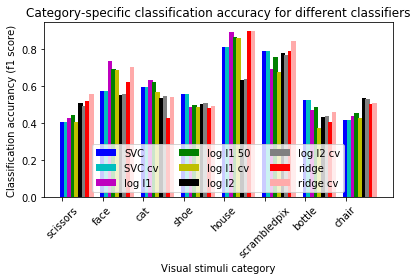

In [5]:
import matplotlib.pyplot as plt
plt.figure()

tick_position = np.arange(len(categories))
plt.xticks(tick_position, categories, rotation=45)

for color, classifier_name in zip(
        ['b', 'c', 'm', 'g', 'y', 'k', '.5', 'r', '#ffaaaa'],
        sorted(classifiers)):
    score_means = [classifiers_scores[classifier_name][category].mean()
                   for category in categories]
    plt.bar(tick_position, score_means, label=classifier_name,
            width=.11, color=color)
    tick_position = tick_position + .09

plt.ylabel('Classification accurancy (f1 score)')
plt.xlabel('Visual stimuli category')
plt.ylim(ymin=0)
plt.legend(loc='lower center', ncol=3)
plt.title(
    'Category-specific classification accuracy for different classifiers')
plt.tight_layout()

4)  Trazar el mapa de 'face' frente a 'house' para los diferentes clasificadores



/home/aletrujim/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/aletrujim/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/aletrujim/anaconda3/lib/python3.6/site-package

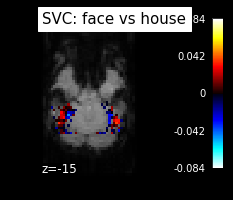

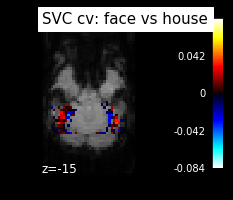

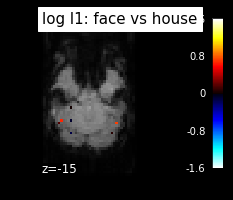

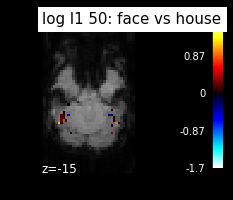

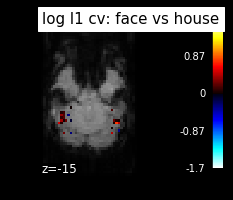

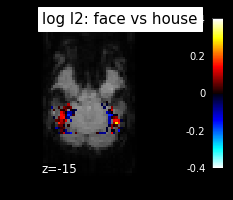

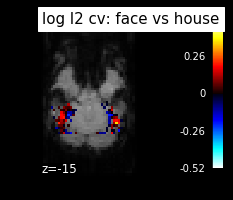

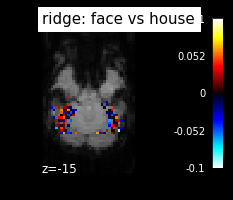

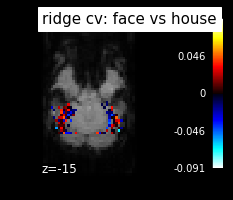

In [6]:
# Usa promedio fondo
from nilearn import image
mean_epi_img = image.mean_img(func_filename)

# Restringir la decodificación para enfrentar 'face' frente 'house'
condition_mask = stimuli.isin(['face', 'house'])
masked_timecourses = masked_timecourses[
    condition_mask[task_mask]]
stimuli = (stimuli[condition_mask] == 'face')
# Transformar los estímulos en valores binarios
stimuli.astype(np.int)

from nilearn.plotting import plot_stat_map, show

for classifier_name, classifier in sorted(classifiers.items()):
    classifier.fit(masked_timecourses, stimuli)

    if hasattr(classifier, 'coef_'):
        weights = classifier.coef_[0]
    elif hasattr(classifier, 'best_estimator_'):
        weights = classifier.best_estimator_.coef_[0]
    else:
        continue
    weight_img = masker.inverse_transform(weights)
    weight_map = weight_img.get_data()
    threshold = np.max(np.abs(weight_map)) * 1e-3
    plot_stat_map(weight_img, bg_img=mean_epi_img,
                  display_mode='z', cut_coords=[-15],
                  threshold=threshold,
                  title='%s: face vs house' % classifier_name)

show()